In [ ]:
import sys
sys.path.append('..')

In [ ]:
from src.preprocess import preprocess_data
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict, concatenate_datasets
import pandas as pd, torch, numpy as np
from tqdm.auto import tqdm, trange
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

## Process data

In [ ]:
df_test = pd.read_excel('./dataset_comments_100_test.xlsx')
df_test2 = pd.read_excel('./a_with_labels.xlsx')
df_test2 = df_test2[['Text', 'my-label']].rename(columns={'Text': 'text', 'my-label': 'label'})
df_test = preprocess_data(df_test)
df_test = df_test[['Text','label']].rename(columns={'Text': 'text'})
df_test = pd.concat([df_test, df_test2], ignore_index=True)

In [ ]:
df = pd.read_excel('./generated.xlsx')
df2 = pd.read_excel('./paraphrased.xlsx')
df = pd.concat([df, df2], ignore_index=True)

train = Dataset.from_pandas(df)
test = Dataset.from_pandas(df_test)
dataset_base = DatasetDict({"train": train,"test": test})

### Other dataset

In [ ]:
from datasets import load_dataset

def map_sentiment(x):
    x['sentiment'] = {0: 'neutral', 1: 'positive', 2: 'negative'}[x['sentiment']]
    return x


dataset = load_dataset("MonoHime/ru_sentiment_dataset").remove_columns('Unnamed: 0')
dataset['test'] = dataset.pop('validation')
dataset = dataset.map(map_sentiment)
dataset = dataset.rename_column("sentiment", "label")
dataset_train = concatenate_datasets([dataset['train'], dataset_base['train']])
dataset_test = concatenate_datasets([dataset['test'].select(range(len(dataset_base['test']))), dataset_base['test']])

## Init a pretrained model and tokenize dataset

In [ ]:
from transformers import AutoModelForSequenceClassification

model_name = "cointegrated/rubert-tiny-sentiment-balanced"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [ ]:
model.config.label2id

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_fn(tokenizer): 
    # this fixes multiprocessing issue
    def _f(x): return tokenizer(x["text"], truncation=True)
    return _f


ds = dataset.\
    map(tokenize_fn(tokenizer), batched=True, remove_columns=['text'], num_proc=1).\
    map(lambda x: {'label': [model.config.label2id[xl] for xl in x['label']]}, batched=True)

## Code for eval and predict

In [ ]:
from src.utils import *

In [ ]:
import matplotlib.pyplot as plt

def update_graph(points: list[list], graph_ax, graph_out, names=None, x_bounds=None, y_bounds=None):
    graph_ax.clear()
    for i, p in enumerate(points): graph_ax.plot(*p, label=names[i] if names else None)
    graph_ax.legend(loc='upper right')
    if x_bounds is not None: graph_ax.set_xlim(*x_bounds)
    if y_bounds is not None: graph_ax.set_ylim(*y_bounds)
    graph_out.update(graph_ax.figure)

In [ ]:
def get_loss(model, dl):
    total_loss = 0.0
    total_batches = 0
    with torch.no_grad():
        for batch in tqdm(dl, leave=True):
            batch = batch.to(model.device)
            total_loss += model(**batch).loss.item()
            total_batches += 1
    return total_loss / total_batches if total_batches > 0 else 0.0

## Training loop

In [ ]:
from torch.utils.data import DataLoader

bs = 16
dl_train = DataLoader(ds["train"], shuffle=True, collate_fn=data_collator, batch_size=bs)
dl_test = DataLoader(ds["test"], shuffle=False, collate_fn=data_collator, batch_size=bs)

In [ ]:
do_eval(model, dl_test)

  0%|          | 0/4 [00:00<?, ?it/s]

{'accuracy': {'negative': 0.0,
  'neutral': 0.8275862336158752,
  'positive': 0.8500000238418579},
 'precision': {'negative': 0.0,
  'neutral': 0.8275862336158752,
  'positive': 0.8095238208770752},
 'recall': {'negative': 0.0,
  'neutral': 0.8275862336158752,
  'positive': 0.8500000238418579},
 'f1': {'negative': 0.0,
  'neutral': 0.8275862336158752,
  'positive': 0.8292683362960815}}

In [ ]:
from types import SimpleNamespace

config = SimpleNamespace(
n_epochs = 5,
window = 500,
cleanup_step = 100,
eval_step = 16
)
# reinitialize model in case we want to change parameters and restart training from scratch
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).cuda()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_max=config.n_epochs)

In [ ]:
weights = torch.tensor(ds['train']['label']).unique(return_counts=True)[1]
weights = weights/weights.sum()

In [ ]:
def loss_fn(logits, labels): return torch.nn.functional.cross_entropy(logits, labels, weight=weights.to(logits.device))

In [ ]:
model.train()
cleanup()

In [ ]:
def train(model, optimizer, dl_train, dl_test, config, figsize=(12,5)):
    fig, ax = plt.subplots(figsize=figsize)
    graph_out = display(fig, display_id=True)
    eval_steps = []
    losses, test_losses = [], []
    step, ewm_loss = 0, 0
    try:
        for _ in trange(config.n_epochs):
            for i, batch in enumerate(tqdm(dl_train, leave=True)):
                step += 1
                batch = batch.to(model.device)
                output = model(**batch)
                loss = loss_fn(output.logits, batch['labels'])
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # sched.step()
            
                
                if i % config.cleanup_step == 0: cleanup()

                w = 1 / min(i+1, config.window)
                ewm_loss = ewm_loss * (1-w) + loss.item() * w
                losses.append(loss.item())
                
                if i % config.eval_step == 0:
                    eval_steps.append(step)
                    model.eval()
                    eval_loss = get_loss(model, dl_test)
                    test_losses.append(eval_loss)
                    model.train()
                update_graph([[losses], [eval_steps, test_losses]], ax, graph_out, names=['loss', 'test loss'])
    except KeyboardInterrupt: print("Stopping training")

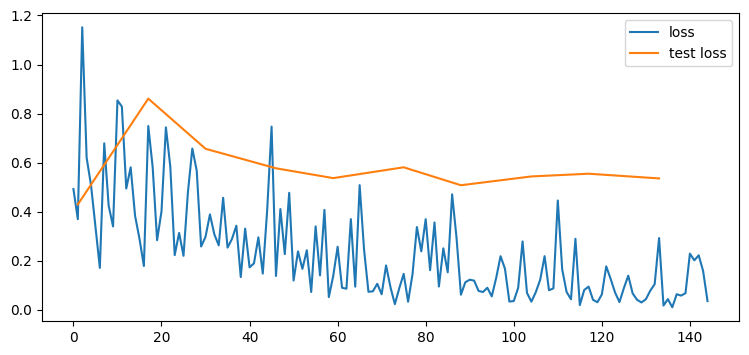

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

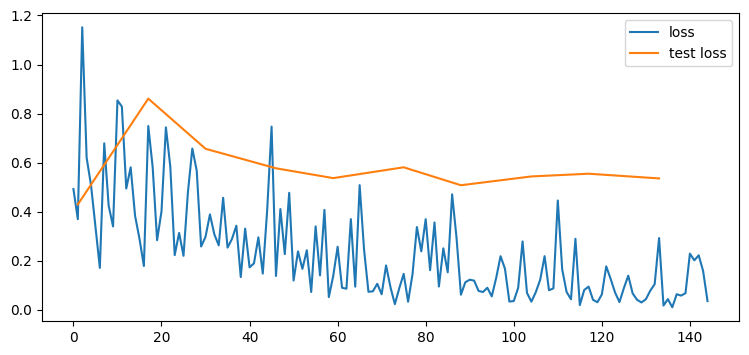

In [ ]:
train(model, optimizer, dl_train, dl_test, config)

In [ ]:
model.save_pretrained('./tuned_model_500_wce')

# Eval model

In [ ]:
do_eval(model, dl_train, agg=True)

  0%|          | 0/29 [00:00<?, ?it/s]

{'accuracy': 0.9452953934669495,
 'precision': 0.9452953934669495,
 'recall': 0.9452953934669495,
 'f1': 0.9452953934669495}

In [ ]:
model.to('cuda')

In [ ]:
do_eval(model.to('cuda'), dl_test)

  0%|          | 0/1 [00:00<?, ?it/s]

{'accuracy': 0.5686274766921997,
 'precision': 0.5373897552490234,
 'recall': 0.7066666483879089,
 'f1': 0.4532356560230255}

# Train with HF Trainer

In [ ]:
from transformers import TrainerCallback

class LogStepLossCallback(TrainerCallback):
    def __init__(self, window=50, figsize=(12,5)):
        fig, self.ax = plt.subplots(figsize=figsize)
        self.graph_out = display(fig, display_id=True)
        self.steps, self.val_steps, self.losses, self.val_losses = [], [], [],[]
        self.ewm_loss, self.window = 0, window
        self.w = 0.1

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Log training loss
            if 'loss' in logs:
                self.steps.append(state.global_step)
                self.ewm_loss = self.ewm_loss * (1-self.w) + logs['loss'] * self.w
                self.losses.append(self.ewm_loss)
            # Log validation loss
            if 'eval_loss' in logs:
                self.val_steps.append(state.global_step)
                self.val_losses.append(logs['eval_loss'])
        update_graph([[self.losses], [self.val_steps, self.val_losses]], self.ax, self.graph_out, names=['loss', 'test loss'])

In [ ]:
# model_name = 'r1char9/rubert-base-cased-russian-sentiment'
model_name = 'clapAI/modernBERT-base-multilingual-sentiment'
# model_name = "cointegrated/rubert-tiny-sentiment-balanced"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).cuda()
ds = dataset.\
    map(tokenize_fn(tokenizer), batched=True, remove_columns=['text'], num_proc=1).\
    map(lambda x: {'label': [model.config.label2id[xl] for xl in x['label']]}, batched=True)

In [ ]:
cleanup()

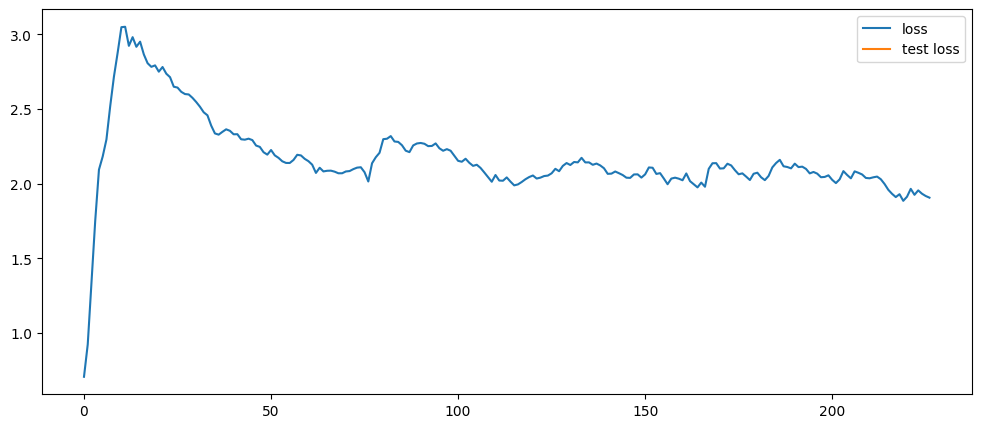

Step,Training Loss,Validation Loss


In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=9e-5,
    per_device_train_batch_size=8,  # Each device's effective batch size
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    warmup_ratio=0.01,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps = 512,
    save_strategy="steps",
    save_steps = 512,
    logging_dir="./logs",
    logging_steps=1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    fp16=True,  # Native AMP
    optim="adamw_torch_fused",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Assuming accuracy metric is used
)

# Define the trainer
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

collator = DataCollatorWithPadding(tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    processing_class=tokenizer,
    data_collator=collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics,
    callbacks=[LogStepLossCallback()],
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation results:", results)